In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
from multiprocessing import Pool
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec
from KDEpy import FFTKDE
from tqdm.auto import tqdm
from math import ceil
import itertools
import scipy
from fast_histogram import histogram2d
import colorcet as cc
import matplotlib.colors as colors
import h5py
import io
from pprint import pprint
from collections import defaultdict

In [4]:
dataset_path = "/data/output/20220226_robustness/dataset.h5"

In [3]:
with h5py.File(dataset_path, "r") as f:
    dX = f["filters"][:].reshape(-1, 9) 

In [5]:
df_meta = pd.read_hdf(dataset_path, "meta")
df_meta["filter_ids"] = df_meta["filter_ids"].apply(lambda s: np.arange(int(s.split(":")[0]), 1 + int(s.split(":")[1])))
df_meta.Robust = df_meta.Robust.apply(bool)

In [10]:
df_meta = pd.concat([df_meta, pd.read_hdf(dataset_path, "meta_sparsity")], axis=1)

In [13]:
df_pairings = pd.read_csv("robust_vs_normal_pairings.csv", index_col=0)

## Create meta

In [5]:
if not "layer_norm" in df_meta.keys():
    df_meta["layer_norm"] = [np.abs(dX[row.filter_ids]).max() for _, row in df_meta.iterrows()]
if not "layer_sparse_filters" in df_meta.keys():
    df_meta["layer_sparse_filters"] = [(np.linalg.norm(dX[row.filter_ids], np.inf, axis=1) <= row.layer_norm / 100).sum() for _, row in df_meta.iterrows()]
df_meta["layer_num_filters"] = [len(row.filter_ids) for _, row in df_meta.iterrows()]
df_meta["layer_sparse_share"] = df_meta["layer_sparse_filters"] / df_meta["layer_num_filters"]

In [33]:
df_meta[["layer_norm", "layer_sparse_filters", "layer_num_filters", "layer_sparse_share"]].to_hdf(dataset_path, "meta_sparsity")

In [6]:
sparse_filter_ids = np.hstack([row.filter_ids[(np.linalg.norm(dX[row.filter_ids], np.inf, axis=1) <= row.layer_norm / 100)] for _, row in tqdm(df_meta.iterrows())])

0it [00:00, ?it/s]

In [34]:
def set_dataset(file, key, value, overwrite=True):
    if key not in file:
        file.create_dataset(key, data=value)
    elif overwrite:
        del file[key]
        file[key] = value

with h5py.File(dataset_path, "a") as f:
    set_dataset(f, "sparse_filter_ids", sparse_filter_ids)

## Analysis

In [9]:
df_meta[df_meta.Robust].layer_sparse_filters.sum() / df_meta[df_meta.Robust].layer_num_filters.sum()

0.09447506891746078

In [10]:
df_meta[~df_meta.Robust].layer_sparse_filters.sum() / df_meta[~df_meta.Robust].layer_num_filters.sum()

0.3948042471447261

In [11]:
num_sparse_filters = {}

for model_name in tqdm(df_meta.model.unique()):
    num_sparse_filters[model_name] = df_meta[df_meta.Name == model_name].layer_sparse_filters.sum()

  0%|          | 0/119 [00:00<?, ?it/s]

In [12]:
entries = []
for model in filter(lambda k: "_extra" in k and k.replace("_extra", "") in num_sparse_filters.keys(), num_sparse_filters.keys()):
    entries.append((model, num_sparse_filters[model] / num_sparse_filters[model.replace("_extra", "")]))

df_sparsity_extra = pd.DataFrame(entries)
df_sparsity_extra

,0,1
0,robustbench_Gowal2020Uncovering_70_16_extra_ci...,0.480511
1,robustbench_Gowal2020Uncovering_extra_cifar100...,35.878385
2,robustbench_Wu2020Adversarial_extra_cifar10_li...,0.242799


In [13]:
entries = []
for model in filter(lambda k: "cifar100" in k and k.replace("cifar100", "cifar10") in num_sparse_filters.keys(), num_sparse_filters.keys()):
    entries.append((model, num_sparse_filters[model], num_sparse_filters[model.replace("cifar100", "cifar10")]))
    
df_sparsity_dataset = pd.DataFrame(entries)
df_sparsity_dataset

,0,1,2
0,hso_normal_training_robustbench_Rebuffi2021Fix...,793725,847969
1,hso_normal_training_robustbench_Rice2020Overfi...,20917,4085459
2,hso_normal_training_robustbench_Hendrycks2019U...,145391,288556
3,hso_normal_training_robustbench_Chen2020Effici...,258858,684582
4,hso_normal_training_robustbench_Wu2020Adversar...,171888,561235
5,robustbench_Addepalli2021Towards_WRN34_cifar10...,160963,966752
6,robustbench_Chen2020Efficient_cifar100_linf_13,482209,874299
7,hso_normal_training_robustbench_Addepalli2021T...,192571,543461
8,robustbench_Chen2021LTD_WRN34_10_cifar100_linf_13,255423,634115
9,robustbench_Hendrycks2019Using_cifar100_linf_13,690522,686874


In [15]:
def agg_by_depth_decile(parent):
    agg = []
    for i, index in enumerate(parent.apply(lambda name: df_meta[df_meta.model == name].index)):
        df = df_meta.loc[index]
        df = df.reset_index()
        df.model_id = i
        df = df.set_index(["model_id", "conv_depth", "conv_depth_norm", "layer_id"])
        agg.append(df)
    selector = pd.concat(agg)
    
    grouper = lambda s: s.apply(lambda s: pd.Series({'result': s["layer_sparse_filters"].sum() / s["layer_num_filters"].sum()}))\
                        .groupby(level=0).result.apply(np.hstack)
    
    first = selector[selector.index.get_level_values("conv_depth") == 0]
    
    stack = []
    
    if len(first) > 0:
        stack.append(grouper(first.groupby(["conv_depth", "model_id"])))
    
    stack.append(grouper(selector.groupby([pd.cut(selector.index.get_level_values(2), np.linspace(0, 1, 11)), "model_id"])))
    
    return pd.concat(stack)

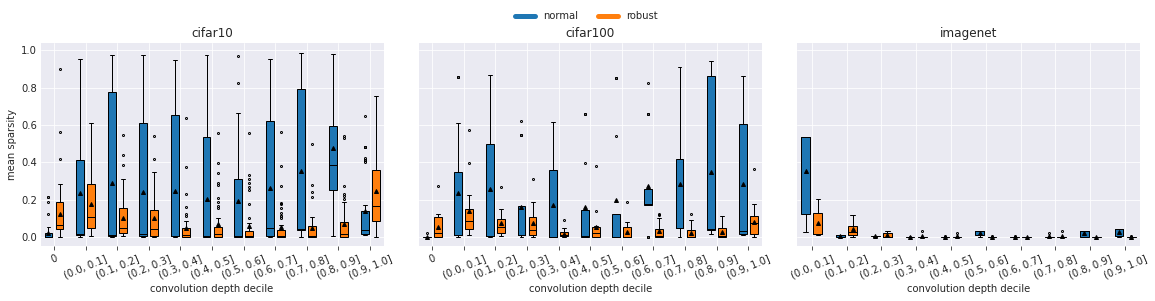

In [17]:
from boxplots import boxplots

with plt.style.context("seaborn-dark"):
    plt.rcParams['xtick.major.size'] = 3.5
    fig, axes = plt.subplots(1, 3, figsize=(16, 4), facecolor="white", sharey=True)
    
    boxplots(
        [
            agg_by_depth_decile(df_pairings[df_pairings.Normal.str.contains("_cifar10_")].Normal),
            agg_by_depth_decile(df_pairings[df_pairings.Robust.str.contains("_cifar10_")].Robust),
        ], labels=["normal", "robust"], ax=axes[0])
    axes[0].set_title("cifar10")

    boxplots(
        [
            agg_by_depth_decile(df_pairings[df_pairings.Normal.str.contains("_cifar100_")].Normal),
            agg_by_depth_decile(df_pairings[df_pairings.Robust.str.contains("_cifar100_")].Robust),
        ], labels=["normal", "robust"], ax=axes[1])
    axes[1].set_title("cifar100")


    boxplots(
        [
            agg_by_depth_decile(df_pairings[df_pairings.Normal.str.contains("_imagenet1k_")].Normal),
            agg_by_depth_decile(df_pairings[df_pairings.Robust.str.contains("_imagenet_")].Robust),
        ], labels=["normal", "robust"], ax=axes[2])
    axes[2].set_title("imagenet")


    handles, labels = axes[1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0,0.05,1,1), ncol=3)
    fig.tight_layout()
    axes[0].set_ylabel("mean sparsity")
    plt.savefig("plots/sparsity_normal_vs_robust.pdf", bbox_inches='tight')